In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import neurokit2 as nk
import scipy.signal
from scipy import stats
import xmltodict


In [2]:
input_path = '/Users/filipesantos/Documents/BioSensory/apple_health_export_2/export.xml'
with open(input_path, 'r') as xml_file:
    input_data = xmltodict.parse(xml_file.read())
#Records list for general health data & imported as Pandas Data Frame
    records_list = input_data['HealthData']['Record']
    df_records = pd.DataFrame(records_list)
    #Workout list for workout data
    workouts_list = input_data['HealthData']['Workout']
    df_workouts = pd.DataFrame(workouts_list)

In [3]:
specific_workout = df_workouts[-2:-1]
specific_workout

,@workoutActivityType,@duration,@durationUnit,@sourceName,@sourceVersion,@device,@creationDate,@startDate,@endDate,MetadataEntry,WorkoutEvent,WorkoutStatistics,WorkoutRoute
202,HKWorkoutActivityTypeRunning,55.35876031517982,min,Filipe’s Apple Watch,8.8.1,"<<HKDevice: 0x281a7bca0>, name:Apple Watch, ma...",2023-10-14 11:55:54 -0700,2023-10-14 11:00:32 -0700,2023-10-14 11:55:53 -0700,"[{'@key': 'HKIndoorWorkout', '@value': '1'}, {...","[{'@type': 'HKWorkoutEventTypeSegment', '@date...",[{'@type': 'HKQuantityTypeIdentifierActiveEner...,NaN


In [4]:
import xml.etree.ElementTree as ET
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

# create element tree object
tree = ET.parse('/Users/filipesantos/Documents/BioSensory/apple_health_export_2/export.xml') 
# for every health record, extract the attributes
root = tree.getroot()
record_list = [x.attrib for x in root.iter('Record')]

In [5]:
record_data = pd.DataFrame(record_list)

# proper type to dates
for col in ['creationDate', 'startDate', 'endDate']:
    record_data[col] = pd.to_datetime(record_data[col])

# value is numeric, NaN if fails
record_data['value'] = pd.to_numeric(record_data['value'], errors='coerce')

# some records do not measure anything, just count occurences
# filling with 1.0 (= one time) makes it easier to aggregate
record_data['value'] = record_data['value'].fillna(1.0)

# shorter observation names
record_data['type'] = record_data['type'].str.replace('HKQuantityTypeIdentifier', '')
record_data['type'] = record_data['type'].str.replace('HKCategoryTypeIdentifier', '')
record_data.tail()

,type,sourceName,sourceVersion,unit,creationDate,startDate,endDate,value,device
531787,HeartRateVariabilitySDNN,Filipe’s Apple Watch,7.6.1,ms,2022-08-29 15:31:11-07:00,2022-08-29 15:30:11-07:00,2022-08-29 15:31:11-07:00,93.1229,"<<HKDevice: 0x281aa4370>, name:Apple Watch, ma..."
531788,HeartRateVariabilitySDNN,Filipe’s Apple Watch,7.6.1,ms,2022-08-30 03:21:10-07:00,2022-08-30 03:20:06-07:00,2022-08-30 03:21:10-07:00,65.5915,"<<HKDevice: 0x281aa4370>, name:Apple Watch, ma..."
531789,HeartRateVariabilitySDNN,Filipe’s Apple Watch,7.6.1,ms,2022-08-30 07:25:24-07:00,2022-08-30 07:24:23-07:00,2022-08-30 07:25:24-07:00,122.4460,"<<HKDevice: 0x281aa4370>, name:Apple Watch, ma..."
531790,HeartRateVariabilitySDNN,Filipe’s Apple Watch,7.6.1,ms,2022-09-02 08:18:02-07:00,2022-09-02 08:16:56-07:00,2022-09-02 08:18:02-07:00,26.2809,"<<HKDevice: 0x281aa4370>, name:Apple Watch, ma..."
531791,HeartRateVariabilitySDNN,Filipe’s Apple Watch,8.8.1,ms,2023-10-14 13:21:24-07:00,2023-10-14 13:20:19-07:00,2023-10-14 13:21:19-07:00,121.9080,"<<HKDevice: 0x281aa4320>, name:Apple Watch, ma..."


In [6]:
new_df = record_data['type'].unique()
new_df

array(['BodyMassIndex', 'Height', 'BodyMass', 'HeartRate',
       'OxygenSaturation', 'BodyFatPercentage', 'LeanBodyMass',
       'StepCount', 'DistanceWalkingRunning', 'BasalEnergyBurned',
       'ActiveEnergyBurned', 'FlightsClimbed', 'AppleExerciseTime',
       'DistanceCycling', 'RestingHeartRate', 'VO2Max',
       'WalkingHeartRateAverage', 'EnvironmentalAudioExposure',
       'HeadphoneAudioExposure', 'WalkingDoubleSupportPercentage',
       'SixMinuteWalkTestDistance', 'AppleStandTime', 'WalkingSpeed',
       'WalkingStepLength', 'WalkingAsymmetryPercentage',
       'StairAscentSpeed', 'StairDescentSpeed', 'AppleWalkingSteadiness',
       'AppleStandHour', 'HeadphoneAudioExposureEvent',
       'HeartRateVariabilitySDNN'], dtype=object)

In [7]:
workout_list = [x.attrib for x in root.iter('Workout')]

# Create the workout_data dataframe. The workout does not contain info such as running distance, as per IOS 16.
workout_data = pd.DataFrame(workout_list)
workout_data['workoutActivityType'] = workout_data['workoutActivityType'].str.replace('HKWorkoutActivityType', '')
workout_data = workout_data.rename({"workoutActivityType": "Type"}, axis=1)

# proper type to dates
for col in ['creationDate', 'startDate', 'endDate']:
    workout_data[col] = pd.to_datetime(workout_data[col])

# # convert string to numeric   
# workout_data['duration'] = pd.to_numeric(workout_data['duration'])
# #workout_data['totalEnergyBurned'] = pd.to_numeric(workout_data['totalEnergyBurned'])
# #workout_data['totalDistance'] = pd.to_numeric(workout_data['totalDistance'])
workout_data.tail()

,Type,duration,durationUnit,sourceName,sourceVersion,device,creationDate,startDate,endDate
199,Running,84.34274260004362,min,Filipe’s Apple Watch,7.6.1,"<<HKDevice: 0x281a6afd0>, name:Apple Watch, ma...",2022-09-02 08:05:46-07:00,2022-09-02 06:41:24-07:00,2022-09-02 08:05:44-07:00
200,Running,22.86468194524447,min,Filipe’s Apple Watch,7.6.1,"<<HKDevice: 0x281a6afd0>, name:Apple Watch, ma...",2022-09-03 07:55:15-07:00,2022-09-03 07:25:05-07:00,2022-09-03 07:55:14-07:00
201,CrossTraining,87.69189816713333,min,Filipe’s Apple Watch,7.6.1,"<<HKDevice: 0x281a6afd0>, name:Apple Watch, ma...",2022-09-03 09:23:07-07:00,2022-09-03 07:55:24-07:00,2022-09-03 09:23:06-07:00
202,Running,55.35876031517982,min,Filipe’s Apple Watch,8.8.1,"<<HKDevice: 0x281a7bca0>, name:Apple Watch, ma...",2023-10-14 11:55:54-07:00,2023-10-14 11:00:32-07:00,2023-10-14 11:55:53-07:00
203,Walking,7.062334948778153,min,Filipe’s Apple Watch,8.8.1,"<<HKDevice: 0x281a7bca0>, name:Apple Watch, ma...",2023-10-14 12:03:20-07:00,2023-10-14 11:56:16-07:00,2023-10-14 12:03:19-07:00


<Axes: xlabel='endDate'>

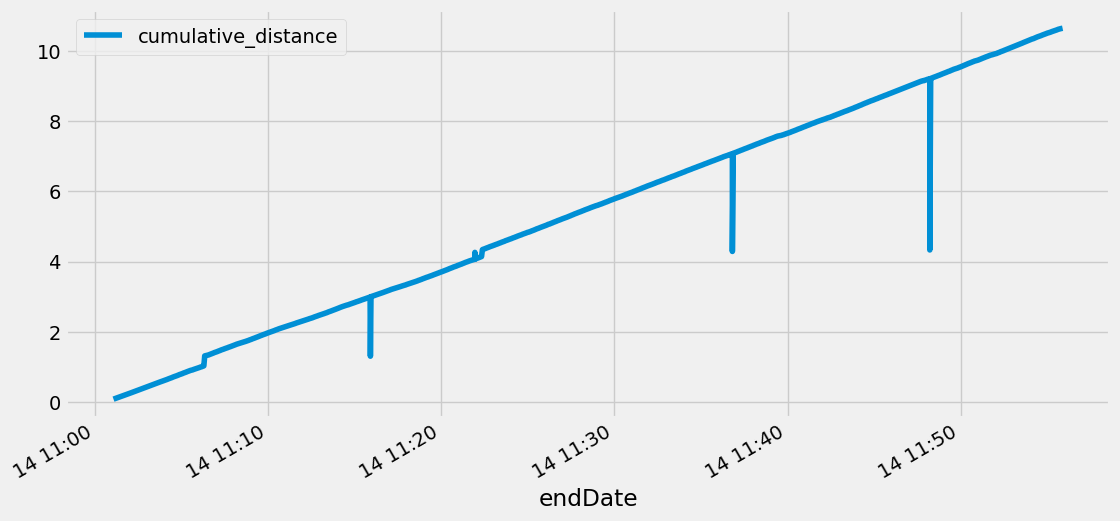

In [8]:
def get_DistanceWalkingRunning(distance_2, workout):
    def get_distance_for_date(distance, start, end):
        distance = distance[distance["startDate"] >= start]
        distance = distance[distance["endDate"] <= end]
        return distance
    return get_distance_for_date(distance_2, workout["startDate"].item(), workout["endDate"].item())

distance_data = record_data[record_data["type"] == "DistanceWalkingRunning"]

# Extract distance statistics for certain workout
last_workout = workout_data.iloc[[-2]]
distance_workout = get_DistanceWalkingRunning(distance_data, last_workout)
distance_workout['cumulative_distance'] = distance_workout['value'].cumsum()

# Create a condition to identify outliers -> Still need to be fixed
#condition = distance_workout['cumulative_distance'] < distance_workout['cumulative_distance'].shift(1)
# Use np.where to replace outliers with the previous value
#distance_workout['cumulative_distance_flag'] = np.where(condition, distance_workout['cumulative_distance'].shift(1), 0)
#print(distance_workout['cumulative_distance_flag'].sum())


#display(distance_workout)
# mind = distance_workout["value"].min()
# maxd = distance_workout["value"].max()
# meand = distance_workout["value"].mean()
distance_workout.plot(x='endDate', y='cumulative_distance',  figsize=(12, 6))

<Axes: xlabel='endDate'>

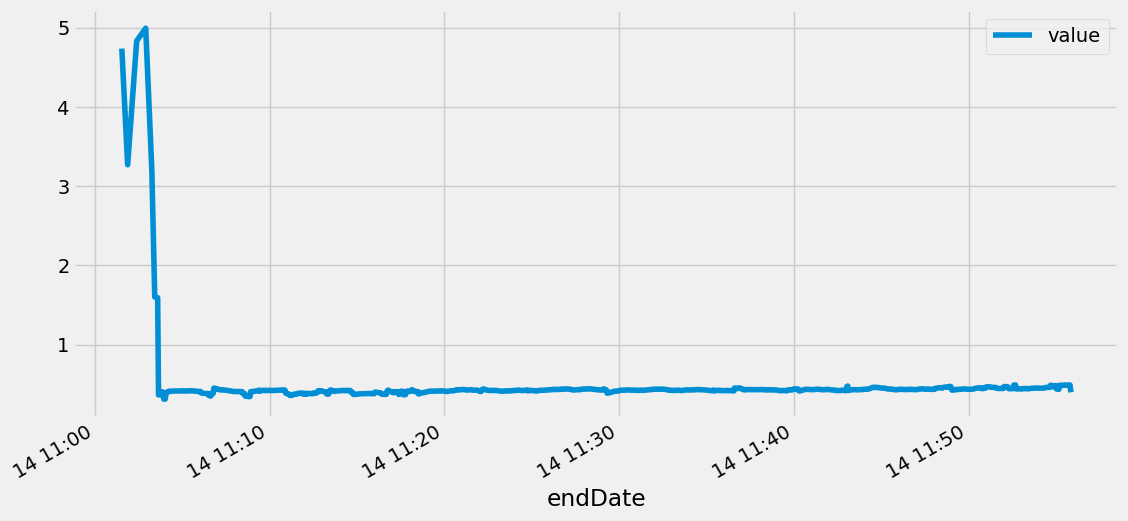

In [9]:
def get_ActiveEnergyBurned_for_workout(energy_2, workout):
    def get_ActiveEnergyBurned_for_date(energy, start, end):
        energy = energy[energy["startDate"] >= start]
        energy = energy[energy["endDate"] <= end]
        return energy
    return get_ActiveEnergyBurned_for_date(energy_2, workout["startDate"].item(), workout["endDate"].item())

energy_data = record_data[record_data["type"] == "ActiveEnergyBurned"]
energy_data.head()

last_workout = workout_data.iloc[[-2]]
energy_workout = get_ActiveEnergyBurned_for_workout(energy_data, last_workout)
#energy_workout.head()
energy_workout.plot(x='endDate', y='value', markersize=8.5,  figsize=(12, 6))


In [10]:
#Parameters:
age = 33
intensity = 0.8

resting_heart_rate_data = record_data[record_data["type"] == "RestingHeartRate"]
average_resting_heart_rate = resting_heart_rate_data.iloc[-5:]['value'].mean()
print(average_resting_heart_rate)
maximum_heart_rate = 220 - age
target_heart_rate = ((maximum_heart_rate - average_resting_heart_rate)*intensity) + average_resting_heart_rate
print(target_heart_rate)
zone_1_upper = ((maximum_heart_rate - average_resting_heart_rate)*0.6) + average_resting_heart_rate
zone_2_upper = ((maximum_heart_rate - average_resting_heart_rate)*0.7) + average_resting_heart_rate
zone_3_upper = ((maximum_heart_rate - average_resting_heart_rate)*0.8) + average_resting_heart_rate
zone_4_upper = ((maximum_heart_rate - average_resting_heart_rate)*0.9) + average_resting_heart_rate

# Zone 1: 50 to 60 percent of maximum heart rate
# Zone 2: 60 to 70 percent of maximum heart rate
# Zone 3: 70 to 80 percent of maximum heart rate
# Zone 4: 80 to 90 percent of maximum heart rate
# Zone 5: 90 to 100 percent of maximum heart rate

# https://www.omnicalculator.com/health/karvonen-formula
# 1. Maximum heart rate = 220 − Age
# 2. Heart rate reserve = Maximum heart rate − Resting heart rate
# 3. Target HR = ((Maximum HR − Resting HR) × Intensity %) + Resting HR

# #Let's use the average values of Resting HR (70 bpm) and Maximum HR typical for a 20-years old (200 bpm)
# The fat burning zone starts at 60% of the intensity of the exercise.
# Target HR = ((200 bpm − 70 bpm) × 60%) + 70 bpm
# Target HR = 148 bpm


47.0
159.0


Running 131.0 173.0 156.2792937399679


<Axes: xlabel='endDate'>

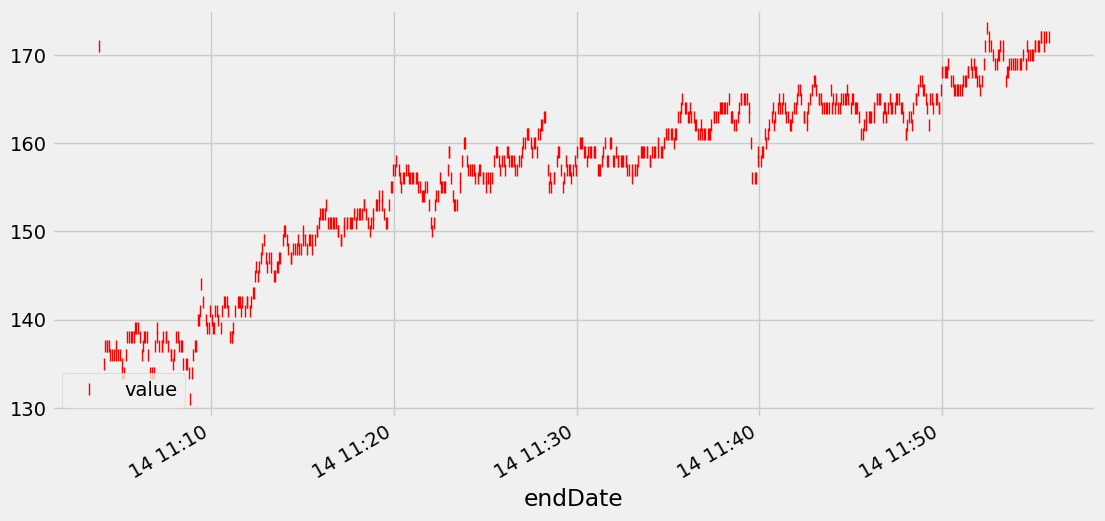

In [11]:
def get_heartrate_for_workout(heartrate, workout):
    def get_heartrate_for_date(hr, start, end):
        hr = hr[hr["startDate"] >= start]
        hr = hr[hr["endDate"] <= end]
        return hr
    return get_heartrate_for_date(heartrate, workout["startDate"].item(), workout["endDate"].item())

heartrate_data = record_data[record_data["type"] == "HeartRate"]

# Extract heartrate statistics for certain workout
last_workout = workout_data.iloc[[-2]]
heartrate_workout = get_heartrate_for_workout(heartrate_data, last_workout)
minh = heartrate_workout["value"].min()
maxh = heartrate_workout["value"].max()
meanh = heartrate_workout["value"].mean()
print(last_workout.Type.item(), minh, maxh, meanh)
heartrate_workout.plot(x='endDate', y= 'value', style='r|', markersize=8.5,  figsize=(12, 6))

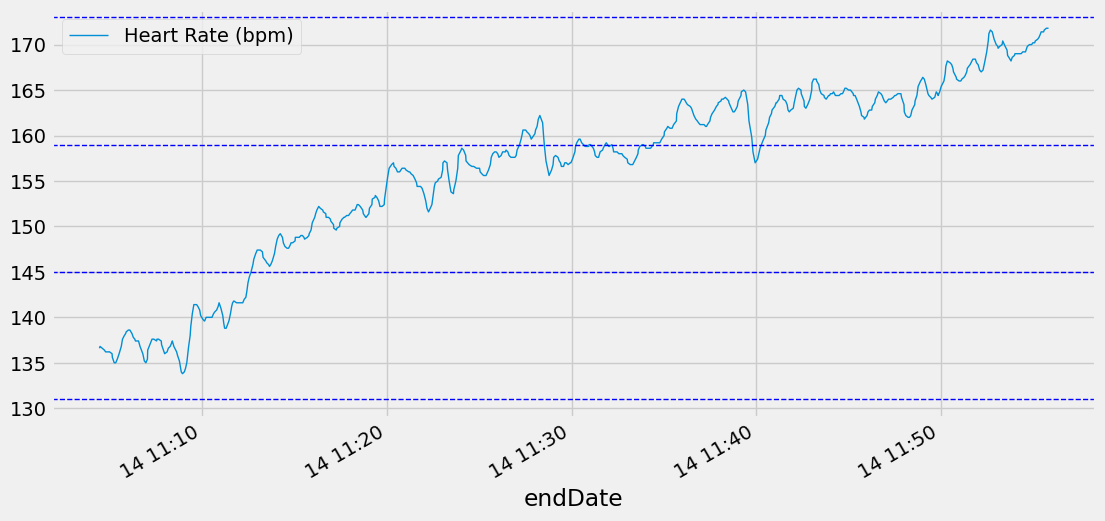

131.0
145.0
159.0
173.0


In [12]:
rolling_parameter = 5

def get_heartrate_for_workout(heartrate, workout):
    def get_heartrate_for_date(hr, start, end):
        hr = hr[hr["startDate"] >= start]
        hr = hr[hr["endDate"] <= end]
        return hr
    return get_heartrate_for_date(heartrate, workout["startDate"].item(), workout["endDate"].item())

heartrate_data = record_data[record_data["type"] == "HeartRate"]

# Extract heartrate statistics for certain workout (In this case, the second to last exercise)
last_workout = workout_data.iloc[[-2]]
heartrate_workout = get_heartrate_for_workout(heartrate_data, last_workout)
minh = heartrate_workout["value"].min()
maxh = heartrate_workout["value"].max()
meanh = heartrate_workout["value"].mean()
#print(last_workout.Type.item(), minh, maxh, meanh)
x_values = pd.Series(heartrate_workout["endDate"])[rolling_parameter :]
y_values = pd.Series(heartrate_workout["value"]).rolling(rolling_parameter).mean()[rolling_parameter :]

df_new = pd.concat([x_values, y_values], axis = 1)
ax = df_new.plot(x='endDate', y='value', linewidth='1', figsize=(12, 6), label='Heart Rate (bpm)')

ax.axhline(y=zone_1_upper, color='b', linestyle='--', label='Zone 1 Upper', lw = 1)
ax.axhline(y=zone_2_upper, color='b', linestyle='--', label='Zone 2 Upper', lw = 1)
ax.axhline(y=zone_3_upper, color='b', linestyle='--', label='Zone 3 Upper', lw = 1)
ax.axhline(y=zone_4_upper, color='b', linestyle='--', label='Zone 4 Upper', lw = 1)
plt.show()

print(zone_1_upper)
print(zone_2_upper)
print(zone_3_upper)
print(zone_4_upper)
duration = x_values.iloc[-1] - x_values.iloc[0]

sampling_rate = (duration/len(df_new['value']))
#display(sampling_rate)

In [20]:
def categorize_variation(diff):
    if diff > 0:
        return 'increased'
    elif diff < 0:
        return 'decreased'
    else:
        return 'no change'
    
def determine_heart_rate_zone(hr):
    if hr <= zone_1_upper:
        return 'Zone 1'
    elif hr <= zone_2_upper:
        return 'Zone 2'
    elif hr <= zone_3_upper:
        return 'Zone 3'
    elif hr <= zone_4_upper:
        return 'Zone 4'
    else:
        return 'Zone 5'

In [32]:
wip_heart_rate_df = pd.DataFrame({
    'timestamp': x_values,
    'heart_rate': y_values
})

# Convert the timestamp to datetime and set as index
wip_heart_rate_df['timestamp'] = pd.to_datetime(wip_heart_rate_df['timestamp'])
wip_heart_rate_df.set_index('timestamp', inplace=True)

# Resample to 3-minute intervals and calculate the mean
resampled_df = wip_heart_rate_df.resample('3T').mean()

# Reset the index to get the desired format
consolidated_df = resampled_df.reset_index()
consolidated_df.columns = ['timestamp', 'average_heart_rate_for_3mins_section']
consolidated_df['heart_rate_diff'] = consolidated_df['average_heart_rate_for_3mins_section'].diff()
consolidated_df['heart_rate_variation'] = consolidated_df['heart_rate_diff'].apply(categorize_variation)
consolidated_df['heart_rate_zone'] = consolidated_df['average_heart_rate_for_3mins_section'].apply(determine_heart_rate_zone)


# Display the DataFrame
display(consolidated_df)

#Defining a baseline for initial tempo of fixed 150 bpms (https://www.runnersneed.com/expert-advice/training/running-and-music-finding-your-bpm.html)
initial_tempo = 150

,timestamp,average_heart_rate_for_3mins_section,heart_rate_diff,heart_rate_variation,heart_rate_zone
0,2023-10-14 11:03:00-07:00,136.590000,NaN,no change,Zone 2
1,2023-10-14 11:06:00-07:00,136.697143,0.107143,increased,Zone 2
2,2023-10-14 11:09:00-07:00,139.832432,3.135290,increased,Zone 2
3,2023-10-14 11:12:00-07:00,146.291429,6.458996,increased,Zone 3
4,2023-10-14 11:15:00-07:00,150.275676,3.984247,increased,Zone 3
5,2023-10-14 11:18:00-07:00,153.638889,3.363213,increased,Zone 3
6,2023-10-14 11:21:00-07:00,154.822857,1.183968,increased,Zone 3
7,2023-10-14 11:24:00-07:00,157.277778,2.454921,increased,Zone 3
8,2023-10-14 11:27:00-07:00,158.621622,1.343844,increased,Zone 3
9,2023-10-14 11:30:00-07:00,158.508571,-0.113050,decreased,Zone 3


In [33]:
#Heart Rate Variation algorithm df
variation_algorithm_df = consolidated_df.copy()
variation_algorithm_df.drop(columns =['heart_rate_zone'], inplace = True)

display(variation_algorithm_df)

,timestamp,average_heart_rate_for_3mins_section,heart_rate_diff,heart_rate_variation
0,2023-10-14 11:03:00-07:00,136.590000,NaN,no change
1,2023-10-14 11:06:00-07:00,136.697143,0.107143,increased
2,2023-10-14 11:09:00-07:00,139.832432,3.135290,increased
3,2023-10-14 11:12:00-07:00,146.291429,6.458996,increased
4,2023-10-14 11:15:00-07:00,150.275676,3.984247,increased
5,2023-10-14 11:18:00-07:00,153.638889,3.363213,increased
6,2023-10-14 11:21:00-07:00,154.822857,1.183968,increased
7,2023-10-14 11:24:00-07:00,157.277778,2.454921,increased
8,2023-10-14 11:27:00-07:00,158.621622,1.343844,increased
9,2023-10-14 11:30:00-07:00,158.508571,-0.113050,decreased


In [37]:
#Heart Rate Zone algorithm df
zone_algorithm_df = consolidated_df.copy()
zone_algorithm_df.drop(columns =['heart_rate_diff', 'heart_rate_variation'], inplace = True)

#TEMPO RECOMMENDATION
def adjust_tempo(zone, previous_tempo):
    if zone == 'Zone 1':
        return previous_tempo * 1.05  # Increase by 10%
    elif zone == 'Zone 2':
        return previous_tempo * 1.025  # Increase by 5%
    elif zone == 'Zone 3':
        return previous_tempo * 0.975  # Decrease by 5%
    elif zone == 'Zone 4':
        return previous_tempo * 0.95  # Decrease by 10%
    else:
        return previous_tempo  # No change for other zones

# Initialize the first tempo
previous_tempo = initial_tempo

# List to store the recommended tempos
recommended_tempos = []

# Iterate through each row to calculate the recommended tempo
for index, row in consolidated_df.iterrows():
    current_tempo = adjust_tempo(row['heart_rate_zone'], previous_tempo)
    rounded_tempo = round(current_tempo)  # Round the tempo to the nearest integer
    recommended_tempos.append(rounded_tempo)
    previous_tempo = current_tempo  # Update the previous tempo
zone_algorithm_df['recommended_tempo'] = recommended_tempos

#VALENCE RECOMMENDATION
def determine_valence(zone):
    if zone == 'Zone 1':
        return 1
    elif zone == 'Zone 2':
        return 1
    elif zone == 'Zone 3':
        return 0.9
    elif zone == 'Zone 4':
        return 0.8
    else:
        return None 

# Apply the function to create the recommended_valence column
zone_algorithm_df['recommended_valence'] = zone_algorithm_df['heart_rate_zone'].apply(determine_valence)

#POPULARITY RECOMMENDATION
def determine_popularity(zone):
    if zone == 'Zone 1':
        return 10
    elif zone == 'Zone 2':
        return 10
    elif zone == 'Zone 3':
        return 9
    elif zone == 'Zone 4':
        return 8
    else:
        return None  # or some default value for other zones

#GENRE RECOMMENDATION
genre_str = '{ "id": 1022, "name": "Pop" }'

zone_algorithm_df['recommended_valence'] = zone_algorithm_df['heart_rate_zone'].apply(determine_valence)
zone_algorithm_df['recommended_popularity'] = zone_algorithm_df['heart_rate_zone'].apply(determine_popularity)
zone_algorithm_df['recommended_genre'] = genre_str

display(zone_algorithm_df)

,timestamp,average_heart_rate_for_3mins_section,heart_rate_zone,recommended_tempo,recommended_valence,recommended_popularity,recommended_genre
0,2023-10-14 11:03:00-07:00,136.590000,Zone 2,154,1.0,10,"{ ""id"": 1022, ""name"": ""Pop"" }"
1,2023-10-14 11:06:00-07:00,136.697143,Zone 2,158,1.0,10,"{ ""id"": 1022, ""name"": ""Pop"" }"
2,2023-10-14 11:09:00-07:00,139.832432,Zone 2,162,1.0,10,"{ ""id"": 1022, ""name"": ""Pop"" }"
3,2023-10-14 11:12:00-07:00,146.291429,Zone 3,157,0.9,9,"{ ""id"": 1022, ""name"": ""Pop"" }"
4,2023-10-14 11:15:00-07:00,150.275676,Zone 3,154,0.9,9,"{ ""id"": 1022, ""name"": ""Pop"" }"
5,2023-10-14 11:18:00-07:00,153.638889,Zone 3,150,0.9,9,"{ ""id"": 1022, ""name"": ""Pop"" }"
6,2023-10-14 11:21:00-07:00,154.822857,Zone 3,146,0.9,9,"{ ""id"": 1022, ""name"": ""Pop"" }"
7,2023-10-14 11:24:00-07:00,157.277778,Zone 3,142,0.9,9,"{ ""id"": 1022, ""name"": ""Pop"" }"
8,2023-10-14 11:27:00-07:00,158.621622,Zone 3,139,0.9,9,"{ ""id"": 1022, ""name"": ""Pop"" }"
9,2023-10-14 11:30:00-07:00,158.508571,Zone 3,135,0.9,9,"{ ""id"": 1022, ""name"": ""Pop"" }"


In [13]:
def get_general_workout_calories_burned():
    final_workout_dict = []
    workout_list = list(root.iter('Workout'))
    for i in range(len(workout_list)):
        workout_dict = workout_list[i].attrib
        WorkoutStatisticsList = list(workout_list[i].iter("WorkoutStatistics"))
        for i, WorkoutStatistics in enumerate(WorkoutStatisticsList):
            if "ActiveEnergyBurned" in WorkoutStatistics.attrib['type']:
                workout_dict['activeEnergyBurned'] = WorkoutStatistics.attrib['sum']
            if "BasalEnergyBurned" in WorkoutStatistics.attrib['type']:
                workout_dict['basalEnergyBurned'] = WorkoutStatistics.attrib['sum']
        final_workout_dict.append(workout_dict)
    final_workout_df = pd.DataFrame(final_workout_dict) #create final_workout_df dataframe
    final_workout_df['workoutActivityType'] = final_workout_df['workoutActivityType'].str.replace('HKWorkoutActivityType', '')
    return final_workout_df.head()

In [14]:
get_general_workout_calories_burned()

,workoutActivityType,duration,durationUnit,sourceName,sourceVersion,device,creationDate,startDate,endDate,activeEnergyBurned,basalEnergyBurned
0,Running,31.96708106597265,min,Filipe’s Apple Watch,7.3.3,"<<HKDevice: 0x281a48af0>, name:Apple Watch, ma...",2021-06-29 05:43:43 -0700,2021-06-29 05:11:44 -0700,2021-06-29 05:43:42 -0700,288.856,40.923
1,FunctionalStrengthTraining,18.1362211505572,min,Filipe’s Apple Watch,7.3.3,"<<HKDevice: 0x281a48af0>, name:Apple Watch, ma...",2021-06-29 06:02:14 -0700,2021-06-29 05:44:05 -0700,2021-06-29 06:02:13 -0700,59.4297,23.229
2,JumpRope,22.96072088479996,min,Filipe’s Apple Watch,7.3.3,"<<HKDevice: 0x281a48af0>, name:Apple Watch, ma...",2021-06-30 08:54:32 -0700,2021-06-30 08:31:34 -0700,2021-06-30 08:54:31 -0700,133.711,28.6895
3,CoreTraining,68.03470391631126,min,Filipe’s Apple Watch,7.3.3,"<<HKDevice: 0x281a48af0>, name:Apple Watch, ma...",2021-06-30 10:03:00 -0700,2021-06-30 08:54:57 -0700,2021-06-30 10:02:59 -0700,110.611,87.2556
4,Running,27.99388436675072,min,Filipe’s Apple Watch,7.3.3,"<<HKDevice: 0x281a48af0>, name:Apple Watch, ma...",2021-07-02 06:19:36 -0700,2021-07-02 05:51:36 -0700,2021-07-02 06:19:35 -0700,279.892,35.8369
